# Project: Classification Model Development 🚀
This notebook explores predictive modeling using **Logistic Regression** and **K-Nearest Neighbors (KNN)**. We focus on rigorous evaluation through performance metrics and interactive visualizations.

## 1. Environment Setup & Dependencies
First, we import the essential libraries for data manipulation, machine learning, and visualization.

* **Core:** `NumPy` and `Pandas` for data handling.
* **Modeling:** `Scikit-Learn` for model selection and implementation.
* **Metrics:** A comprehensive suite including `F1-Score`, `Accuracy` for evaluation.
* **Visualization:** `Plotly` for high-quality, interactive charts.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px


## 2. Data Acquisition & Preliminary Exploration 🔍

In this section, we load the raw dataset and perform initial checks to understand the feature space and data consistency.

### 2.1. Dataset Loading
We load the `Social_Network_Ads` dataset. This data typically contains demographic information used to predict whether a user will purchase a product.

In [2]:
df = pd.read_csv('Social_Network_Ads.csv')


In [3]:
df.head(15)


,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
5,15728773,Male,27,58000,0
6,15598044,Female,27,84000,0
7,15694829,Female,32,150000,1
8,15600575,Male,25,33000,0
9,15727311,Female,35,65000,0


### 2.2. Feature Inspection & Unique Values
We examine the categorical features to understand the diversity of the labels and ensure there are no unexpected categories.

In [4]:
df['Gender'].value_counts()


Gender
Female    204
Male      196
Name: count, dtype: int64

### 2.3. Data Cleaning & Dimensionality Reduction ✂️
To optimize the model's performance and remove noise, we drop irrelevant columns.

* **Action:** Dropping `User ID` as it is a unique identifier with no statistical significance for the prediction task.


In [5]:
df = df.drop('User ID', axis= 1 )


### 2.4. Data Integrity Check (Missing Values)
Before proceeding to modeling, we must ensure the dataset is complete. A null-value check is performed to determine if imputation is required.

In [6]:
df.isnull().sum()


Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

## 3. Exploratory Data Analysis (EDA): Univariate Analysis 📊

We perform a univariate analysis to understand the distribution of individual variables and identify any anomalies or imbalances within the features and the target label.

### Key Objectives:
* **Outlier Detection:** Using Box Plots for `Age` and `EstimatedSalary` to visualize the spread and identify potential outliers that could impact distance-based models (e.g., KNN).
* **Class Balance Check:** Using a Pie Chart for the `Purchased` variable to determine if there is a class imbalance that might require specialized handling during training.

In [7]:
fig = px.box(df , x ='Age' ) 
fig


In [8]:
fig = px.box(df , x ='EstimatedSalary' ) 
fig


In [9]:
fig = px.pie(df , names= 'Purchased')
fig


## 4. Data Partitioning: Train-Test Split 🧪

Before training our models, we must split the dataset into two subsets. This prevents **overfitting** and allows us to evaluate the model's performance on unseen data, simulating a real-world scenario.

### Methodology:
* **Features (X):** The independent variables (Age, Estimated Salary, etc.) used for prediction.
* **Target (y):** The dependent variable (`Purchased`) we are trying to predict.
* **Split Ratio:** We typically use an **80/20** split to ensure the model has enough data to learn while maintaining a robust evaluation set.
* **Random State:** A fixed seed is used to ensure the results are reproducible.

In [10]:
X = df.drop('Purchased', axis=1)
y = df['Purchased']


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, stratify=y
)


# 🛠 Pipeline Setup for Logistic Regression & KNN

In this section, we prepare the preprocessing and pipelines for each model:

1️⃣ **Identify Numeric and Categorical Columns**  
- Numeric columns: Age, EstimatedSalary  
- Categorical columns: Gender  

2️⃣ **Prepare Preprocessing**  
- StandardScaler for numeric columns  
- OneHotEncoder for categorical columns (drop first category to avoid dummy variable trap)  

3️⃣ **Set Up Cross-Validation**  
- Using StratifiedKFold to split the data evenly across classes  

4️⃣ **Create Pipelines for Each Model**  
- Logistic Regression Pipeline  
- K-Nearest Neighbors Pipeline


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

num_cols = ['Age', 'EstimatedSalary']
cat_cols = ['Gender']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False), cat_cols),
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000))
])

knn_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', KNeighborsClassifier())
])

# 🤝 Ensemble Setup with VotingClassifier

In this section, we combine the Logistic Regression and KNN pipelines into an ensemble model using soft voting:

- **VotingClassifier**: Aggregates predictions from multiple models.
- **Soft voting**: Uses predicted probabilities to make the final decision, giving a weighted consensus.
- **Estimators**:  
  - `'lr'` → Logistic Regression pipeline  
  - `'knn'` → K-Nearest Neighbors pipeline


In [13]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('lr', log_pipe),
        ('knn', knn_pipe)
    ],
    voting='soft'
)


# 🧪 Hyperparameter Tuning with GridSearchCV

In this section, we perform hyperparameter tuning for our ensemble model using GridSearchCV:

- **param_grid**: Defines the parameters to try for each estimator in the ensemble:
  - `'lr__model__C'` → Regularization strength for Logistic Regression
  - `'knn__model__n_neighbors'` → Number of neighbors for KNN

- **GridSearchCV**:
  - `estimator` → The ensemble model combining Logistic Regression and KNN
  - `cv` → StratifiedKFold cross-validation
  - `scoring` → F1-score used to evaluate performance
  - `n_jobs=-1` → Use all CPU cores for faster computation

- **grid.fit(X_train, y_train)** → Trains the ensemble on all combinations of parameters and finds the best set.


In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'lr__model__C': [0.1, 1, 10],                # Logistic Regression
    'knn__model__n_neighbors': [3, 5, 7, 9],     # KNN: عدد الجيران
    'knn__model__weights': ['uniform', 'distance']  # KNN: وزن الجيران
}
grid = GridSearchCV(
    ensemble,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train, y_train)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",VotingClassif...voting='soft')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'knn__model__n_neighbors': [3, 5, ...], 'knn__model__weights': ['uniform', 'distance'], 'lr__model__C': [0.1, 1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time fo

# 📊 Test Set Evaluation

In this section, we evaluate the performance of the best ensemble model on the test set:

1️⃣ **Predictions**:  
- `model = grid.best_estimator_` → Get the best model from GridSearchCV  
- `y_pred = model.predict(X_test)` → Predict labels for the test set  

2️⃣ **Metrics**:  
- **Accuracy** → Overall proportion of correctly classified samples  
- **Classification Report** → Precision, Recall, F1-score for each class  

3️⃣ **Confusion Matrix**:  
- Visualizes the number of correct and incorrect predictions for each class  
- `sns.heatmap` → Plots a heatmap of the confusion matrix for better visualization


Test Accuracy: 90.00%
------------------------------
Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.90      0.92        51
           1       0.84      0.90      0.87        29

    accuracy                           0.90        80
   macro avg       0.89      0.90      0.89        80
weighted avg       0.90      0.90      0.90        80

------------------------------


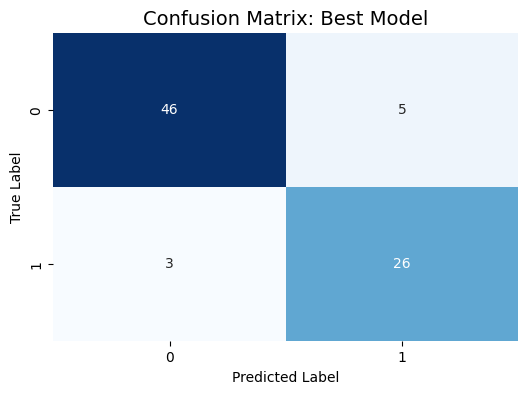

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = grid.best_estimator_
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.2%}")
print("-" * 30)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("-" * 30)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Best Model', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [16]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)


F1 Score: 0.8666666666666667
